In [1]:
# import pandas as pd
# import numpy as np

# df = pd.read_csv('sudoku-3m.csv', index_col='id')
# df['puzzle'] = df['puzzle'].str.replace('.', '0')
# #df = df[df['difficulty'] == 0.0]
# quizzes = np.array([list(puzzle) for puzzle in df['puzzle'].values.tolist()], dtype=np.int32).reshape(-1, 9, 9)
# solutions = np.array([list(puzzle) for puzzle in df['solution'].values.tolist()], dtype=np.int32).reshape(-1, 9, 9)

# quizzes_hard = quizzes
# solutions_hard = solutions

In [2]:
import numpy as np

quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        quizzes[i, j] = q
        solutions[i, j] = s
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

In [3]:
#quizzes = np.concatenate((quizzes, quizzes_hard), axis=0)
#solutions = np.concatenate((solutions, solutions_hard), axis=0)

In [4]:
quizzes[0]

array([[0, 0, 4, 3, 0, 0, 2, 0, 9],
       [0, 0, 5, 0, 0, 9, 0, 0, 1],
       [0, 7, 0, 0, 6, 0, 0, 4, 3],
       [0, 0, 6, 0, 0, 2, 0, 8, 7],
       [1, 9, 0, 0, 0, 7, 4, 0, 0],
       [0, 5, 0, 0, 8, 3, 0, 0, 0],
       [6, 0, 0, 0, 0, 0, 1, 0, 5],
       [0, 0, 3, 5, 0, 8, 6, 9, 0],
       [0, 4, 2, 9, 1, 0, 3, 0, 0]])

In [5]:
solutions[0]

array([[8, 6, 4, 3, 7, 1, 2, 5, 9],
       [3, 2, 5, 8, 4, 9, 7, 6, 1],
       [9, 7, 1, 2, 6, 5, 8, 4, 3],
       [4, 3, 6, 1, 9, 2, 5, 8, 7],
       [1, 9, 8, 6, 5, 7, 4, 3, 2],
       [2, 5, 7, 4, 8, 3, 9, 1, 6],
       [6, 8, 9, 7, 3, 4, 1, 2, 5],
       [7, 1, 3, 5, 2, 8, 6, 9, 4],
       [5, 4, 2, 9, 1, 6, 3, 7, 8]])

In [6]:
def sudoku_2_probs(sudoku):
    probs = np.zeros((9,9,10))
    for i in range(9):
        for j in range(9):
            if sudoku[i, j] > 0:
                probs[i, j, sudoku[i,j]-1] = 1
            else:
                probs[i, j, -1] = 1
    return probs

In [7]:
def index_2_node(i, j):
    """Given 0<= i,j <= 8, returns 0<=node<=80"""
    node = 9*i + j
    return node

def node_2_index(node):
    """Given 0<=node<=80, returns 0<= i,j <= 8"""
    i, j = node // 9, node % 9
    return i, j

In [8]:
import torch
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

square_edges = []
horizontal_edges = []
vertical_edges = []
self_edges = []

for node_source in range(81):
    for node_dest in range(81):
        i_source, j_source = node_2_index(node_source)
        i_dest, j_dest = node_2_index(node_dest)
        
        if node_source == node_dest:
            self_edges.append((node_source, node_dest))
        
        if (node_source != node_dest) and (i_source // 3 == i_dest // 3) and (j_source // 3 == j_dest // 3):
            square_edges.append((node_source, node_dest))
            
        if (node_source != node_dest) and (i_source == i_dest):
            vertical_edges.append((node_source, node_dest))
            
        if (node_source != node_dest) and (j_source == j_dest):
            horizontal_edges.append((node_source, node_dest))
            
G_data = {('cell', 'square', 'cell'): ([source for source, dest in square_edges],
                                       [dest for source, dest in square_edges]),
          ('cell', 'horizontal', 'cell'): ([source for source, dest in horizontal_edges],
                                           [dest for source, dest in horizontal_edges]),
          ('cell', 'vertical', 'cell'): ([source for source, dest in vertical_edges],
                                         [dest for source, dest in vertical_edges])
         }

base_graph = dgl.heterograph(G_data)

Using backend: pytorch


In [9]:
import copy

def sudoku_2_graph(sudoku):
    probs = sudoku_2_probs(sudoku)
    g = copy.deepcopy(base_graph)
    g.ndata['probs'] = torch.tensor(probs.reshape((81, 10)), dtype=torch.float)
    return g

def sudoku_2_sol(sudoku):
    sol = torch.tensor([i-1 for i in sudoku.reshape(81)], dtype=torch.long)
    return sol

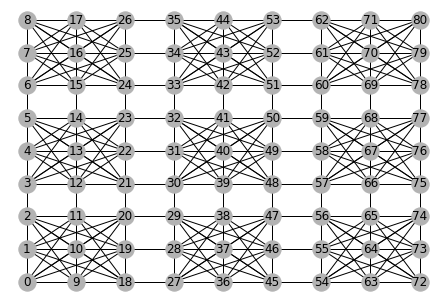

In [10]:
import networkx as nx

nx_G = dgl.to_homogeneous(base_graph).to_networkx().to_undirected()

pos = {node: node_2_index(node) for node in range(81)}
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [11]:
from torch.utils.data import Dataset

class SudokuGraphDataset(Dataset):
    
    def __init__(self, quizzes, solutions):
        self.quizzes = quizzes
        self.solutions = solutions

    def __len__(self):
        return len(self.quizzes)

    def __getitem__(self, idx):
        g = sudoku_2_graph(self.quizzes[idx])
        sol = sudoku_2_sol(self.solutions[idx])
        sample = (g, sol)
        return sample

In [352]:
dataset = SudokuGraphDataset(quizzes, solutions)

data_loader = dgl.dataloading.GraphDataLoader(
    dataset, batch_size=100, shuffle=True, drop_last=False)

In [355]:
# import dgl.nn.pytorch as dglnn

# class MyModel(torch.nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.linked_layer = dglnn.SAGEConv(10, 9, 'mean')

#         self.conv = dglnn.HeteroGraphConv({
#                     'square' : dglnn.SAGEConv(10, 9, 'mean'),
#                     'horizontal' : self.linked_layer,
#                     'vertical' : self.linked_layer},
#                     aggregate='mean')
        
#     def forward(self, g, x):
#         h = {'cell': x}
#         h = self.conv(g, h)
#         h = h['cell']
#         return h
    
# model = MyModel()

# loss_func = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# epoch_losses = []
# for epoch in range(80):
#     epoch_loss = 0
#     for iter, (g, sol) in enumerate(data_loader):
#         prediction = model(g, g.ndata['probs'])
#         loss = loss_func(prediction, sol.flatten())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.detach().item()
#         print(loss.item())
#     epoch_loss /= (iter + 1)
#     print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
#     epoch_losses.append(epoch_loss)

2.262650728225708
2.1498963832855225
2.0608527660369873
1.9806660413742065
1.908307433128357
1.84047269821167
1.7743240594863892
1.7105162143707275
1.6480132341384888
1.5899899005889893
1.5405198335647583
1.4992519617080688
1.4626917839050293
1.4267932176589966
1.3946380615234375
1.3678284883499146
1.3464683294296265
1.321300983428955
1.2986557483673096
1.2868001461029053
1.2706290483474731
1.2621046304702759
1.2473863363265991
1.2316150665283203
1.22975492477417
1.2192871570587158
1.209551215171814
1.2011709213256836
1.1951345205307007
1.1900863647460938
1.1822316646575928
1.1769945621490479
1.1726224422454834
1.1655876636505127
1.157114863395691
1.1608176231384277
1.1527117490768433
1.1457067728042603
1.1390882730484009
1.1362894773483276
1.1370387077331543
1.130385160446167
1.1271222829818726
1.1259969472885132
1.1172643899917603
1.1116323471069336
1.1087620258331299
1.1099430322647095
1.1005449295043945
1.0980178117752075
1.0961341857910156
1.0917192697525024
1.0889753103256226
1.0

KeyboardInterrupt: 

In [344]:
import dgl.nn.pytorch as dglnn

def my_agg_func(tensors, dsttype):
    # tensors: is a list of tensors to aggregate
    # dsttype: string name of the destination node type for which the
    #          aggregation is performed
    stacked = torch.cat(tensors, dim=1)
    return stacked

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.relu = torch.nn.LeakyReLU()
        hdim = 50
        
        self.linked_layer = dglnn.GraphConv(hdim, hdim, activation=self.relu)

        self.conv = dglnn.HeteroGraphConv({
                    'square' :  dglnn.GraphConv(hdim, hdim, activation=self.relu),
                    'horizontal' : self.linked_layer,
                    'vertical' : self.linked_layer},
                    aggregate=my_agg_func)
        
        self.lin_m1 = torch.nn.Linear(hdim, hdim)
        
        self.lin_hd1 = torch.nn.Linear(3*hdim + hdim + 10, hdim)
      
        self.lin_y2 = torch.nn.Linear(hdim, 9)
        self.lin_h2 = torch.nn.Linear(hdim, hdim)
        
    def forward(self, g, x, h):
        # prepare message
        m = self.relu(self.lin_m1(h))
        
        # aggregate messages
        m = self.conv(g, {'cell': m})
        m = m['cell']

        # create hidden state
        hidden = self.relu(self.lin_hd1(torch.cat((h, x, m), dim=1)))
        
        # we create the two outputs y and y separately from hidden
        
        # create output
        y = self.lin_y2(hidden)
        
        # create h output
        h = self.lin_h2(hidden)
        
        return y, hidden
    
#model = MyModel()

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (g, sol) in enumerate(data_loader):
        h = torch.zeros((g.ndata['probs'].shape[0], 50))
        loss = 0
        final_loss = 0
        for rep in range(20):
            prediction, h = model(g, g.ndata['probs'], h)
            loss += loss_func(prediction, sol.flatten()) / 20
        final_loss  = loss_func(prediction, sol.flatten())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        epoch_loss += loss.detach().item()
        print(loss.item(), final_loss.item())
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

0.11851375550031662 0.0001578573283040896
0.1271284520626068 0.01096379105001688
0.12165368348360062 0.0024569283705204725
0.12221494317054749 0.004480247851461172
0.12277277559041977 0.0025246178265661
0.11824297159910202 0.0001260990247828886
0.12781867384910583 0.017103027552366257
0.12166942656040192 0.003357515437528491
0.12300744652748108 0.003959037363529205
0.12581853568553925 0.008780278265476227
0.12672246992588043 0.014015834778547287
0.12204394489526749 0.005114084575325251
0.12486331164836884 0.009876349940896034
0.126090407371521 0.007487897295504808
0.12285879999399185 0.0026094545610249043


KeyboardInterrupt: 

In [335]:
# Notes: hdim = 50 is good enough, with maybe 20 reps, need final loss to be below 0.01. More than 20 steps seems to cause issues

In [99]:
def fill_sudoku_stepwise(sudoku):
    g = sudoku_2_graph(sudoku)
   
    h = torch.zeros((g.ndata['probs'].shape[0], 100))
    for rep in range(32):
        prediction, h = model(g, g.ndata['probs'], h)
        
    #prediction = model(g, g.ndata['probs'])
    softmax = torch.nn.Softmax(dim=1)
    prediction = softmax(prediction)
    
    max_prob = 0
    i_max = -1
    for i in range(81):
        #if True:
        if sudoku[node_2_index(i)] == 0:
            i_prob = prediction[i].max().item()
            if i_prob > max_prob:
                max_prob = i_prob
                i_max = i
    sudoku[node_2_index(i_max)] = prediction[i_max].argmax().item()+1
    return sudoku

In [342]:
def fill_sudoku_probabilistic(sudoku):
    g = sudoku_2_graph(sudoku)
    h = torch.zeros((g.ndata['probs'].shape[0], 50))
    for rep in range(20):
        prediction, h = model(g, g.ndata['probs'], h)
        
    #prediction = model(g, g.ndata['probs'])
    softmax = torch.nn.Softmax(dim=1)
    prediction = softmax(prediction)
    
    
    # predictions are made when p(prediction) > 0.6. If no cells have a probability > 0.6, the highest is chosen.
    min_prob = min(0, prediction[sudoku.flatten() == 0].max())
    for i in range(81):
        if sudoku[node_2_index(i)] == 0:
            prob = prediction[i].max().item()
            if prob >= min_prob:
                sudoku[node_2_index(i)] = prediction[i].argmax().item()+1
    return sudoku

In [101]:
def check_answer(sudoku, sol):
    g = sudoku_2_graph(sudoku)
    h = torch.zeros((g.ndata['probs'].shape[0], 3*9))
    for rep in range(64):
        prediction, h = model(g, g.ndata['probs'], h)
        
    #prediction = model(g, g.ndata['probs'])
    softmax = torch.nn.Softmax(dim=1)
    prediction = softmax(prediction)
    
    max_prob = 0
    i_max = -1
    for i in range(81):
        #if True:
        if sudoku[node_2_index(i)] == 0:
            i_prob = prediction[i].max().item()
            if i_prob > max_prob:
                max_prob = i_prob
                i_max = i
    return sol[node_2_index(i_max)] == prediction[i_max].argmax().item()+1

In [155]:
%%time
import random
accuracy = 0
for i in range(1, 1001):
    ind = random.randrange(quizzes.shape[0])
    sudoku = quizzes[ind].copy()
    sol = solutions[ind]
    if check_answer(sudoku, sol):
        accuracy += 1
    if i % 1 == 0:
        print(i, accuracy/i)

1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0


KeyboardInterrupt: 

In [354]:
%%time
import random
accuracy = 0
steps = 0
for i in range(1, 1001):
    ind = random.randrange(quizzes.shape[0])
    sudoku = quizzes[ind].copy()
    sol = solutions[ind]
    step = 0
    while 0 in sudoku:
        sudoku = fill_sudoku_probabilistic(sudoku)
        step += 1
    if not(False in (sol == sudoku)):
        accuracy += 1
    steps += step
    if i % 1 == 0:
        print(i, accuracy/i, steps/i)

1 1.0 1.0
2 0.5 1.0
3 0.6666666666666666 1.0
4 0.75 1.0
5 0.8 1.0
6 0.8333333333333334 1.0
7 0.8571428571428571 1.0
8 0.875 1.0
9 0.8888888888888888 1.0
10 0.9 1.0
11 0.9090909090909091 1.0
12 0.9166666666666666 1.0
13 0.9230769230769231 1.0
14 0.9285714285714286 1.0
15 0.9333333333333333 1.0
16 0.875 1.0
17 0.8823529411764706 1.0
18 0.8888888888888888 1.0
19 0.8947368421052632 1.0
20 0.9 1.0
21 0.9047619047619048 1.0
22 0.9090909090909091 1.0
23 0.9130434782608695 1.0
24 0.9166666666666666 1.0
25 0.92 1.0
26 0.9230769230769231 1.0
27 0.8888888888888888 1.0
28 0.8928571428571429 1.0
29 0.896551724137931 1.0
30 0.9 1.0
31 0.9032258064516129 1.0
32 0.90625 1.0
33 0.9090909090909091 1.0
34 0.9117647058823529 1.0


KeyboardInterrupt: 